Import the necessary libraries.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

# Part 0 - Import Data

Import and clean data.

In [65]:
df = pd.read_csv('VaR_data.csv')
df = df.drop(1, axis = 0).reset_index(drop=True)
result = [f"{col}_{df.iloc[0][col]}" for col in df.columns]
df.columns = result
df = df.drop(0, axis = 0).reset_index(drop=True)
for col in list(df.columns)[1:]:
    df[col] = df.loc[:,col].astype(float)
df = df.rename(columns = {df.columns[0]:'Date'})
df['Date'] = pd.to_datetime(df['Date'])

# Part 1 - Calculate PnL & Portfolio Returns

Portfolio w/ 3.5 million shares of AAL, 2.5 million shares of DAL, 1.5 million shares of UAL.

In [66]:
mil = 10**6
portfolio_dict = {'AAL': int(3.5*mil), 'DAL': int(2.5*mil), 'UAL': int(1.5*mil)}
portfolio_dict

working_df = df.copy().loc[:,['Date','Adj Close_AAL', 'Adj Close.1_DAL', 'Adj Close.2_UAL']]

portfolio_values_list = []
for i in range(working_df.shape[0]):
    aal_price = working_df.loc[i,'Adj Close_AAL']
    dal_price = working_df.loc[i,'Adj Close.1_DAL']
    ual_price = working_df.loc[i,'Adj Close.2_UAL']

    aal_value = aal_price * portfolio_dict['AAL']
    dal_value = dal_price * portfolio_dict['DAL']
    ual_value = ual_price * portfolio_dict['UAL']

    portfolio_value = aal_value + dal_value + ual_value

    portfolio_values_list.append(portfolio_value)

concat = pd.DataFrame({'Portfolio':portfolio_values_list})
portfolio_df = pd.concat([working_df,concat], axis = 1)

portfolio_df['Portfolio Returns'] = np.log(portfolio_df['Portfolio'] / portfolio_df['Portfolio'].shift(1))

portfolio_df

,Date,Adj Close_AAL,Adj Close.1_DAL,Adj Close.2_UAL,Portfolio,Portfolio Returns
0,2024-02-28,15.46,41.560246,44.759998,2.251506e+08,NaN
1,2024-02-29,15.68,41.817463,45.490002,2.276587e+08,0.011078
2,2024-03-01,15.66,41.708645,44.840000,2.263416e+08,-0.005802
3,2024-03-04,14.81,41.124962,44.139999,2.208574e+08,-0.024528
4,2024-03-05,14.67,41.352493,43.740002,2.203362e+08,-0.002363
...,...,...,...,...,...,...
246,2025-02-21,15.23,59.854134,95.889999,3.467753e+08,-0.060038
247,2025-02-24,15.31,61.340515,97.769997,3.535913e+08,0.019465
248,2025-02-25,15.13,61.639782,96.580002,3.519245e+08,-0.004725
249,2025-02-26,15.18,61.550003,97.400002,3.531050e+08,0.003349


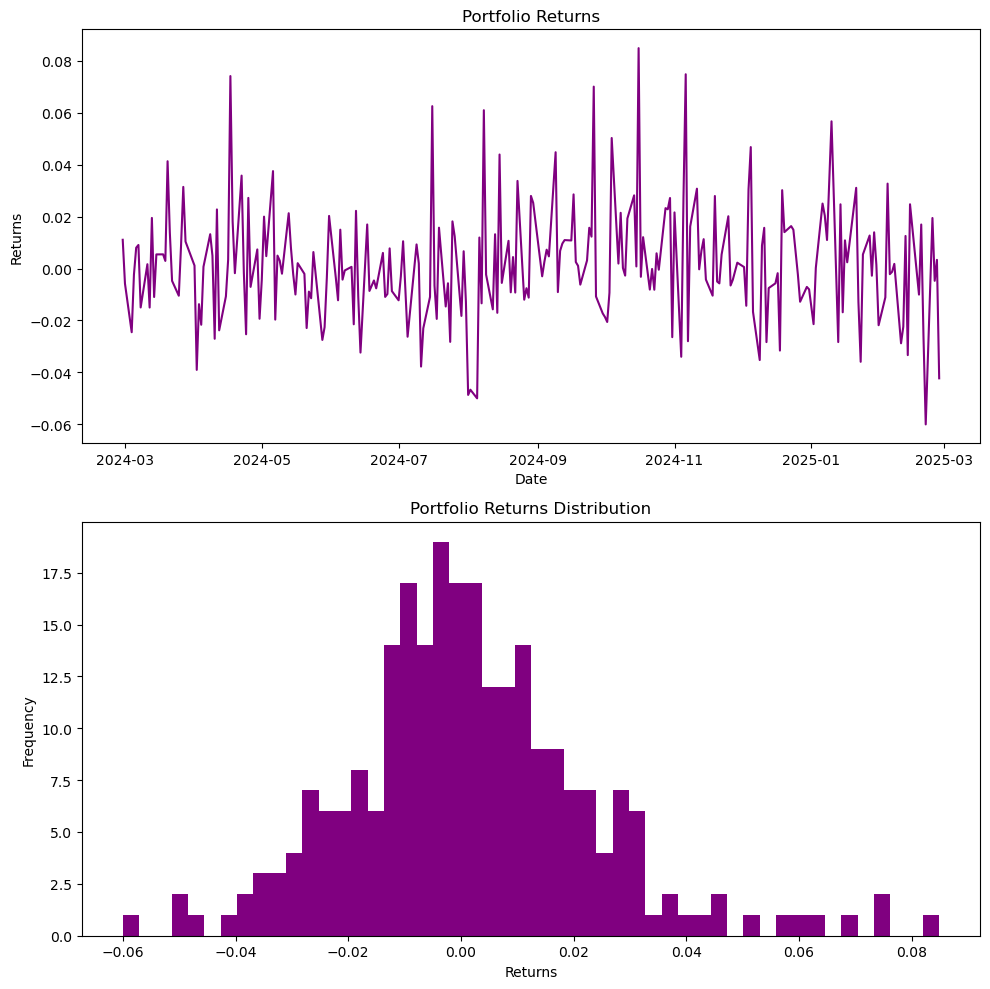

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio Returns'], color='purple')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Returns')

plt.subplot(2, 1, 2)
plt.hist(portfolio_df['Portfolio Returns'], bins=50, color='purple', alpha=1)
plt.title('Portfolio Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Part 2 - Parametric VaR

$ VaR = Z_\alpha * \sigma_{\text{portfolio}} * (\text{Portfolio Value}) $

In [68]:
# Calculate current portfolio market value and weights
latest_prices = working_df.iloc[-1, 1:]

market_values = np.array([portfolio_dict['AAL'] * latest_prices['Adj Close_AAL'],
                          portfolio_dict['DAL'] * latest_prices['Adj Close.1_DAL'],
                          portfolio_dict['UAL'] * latest_prices['Adj Close.2_UAL']
])
total_value = np.sum(market_values)
weights = market_values / total_value

# Calculate log returns
working_df['AAL returns'] = np.log(working_df['Adj Close_AAL'] / working_df['Adj Close_AAL'].shift(1))
working_df['DAL returns'] = np.log(working_df['Adj Close.1_DAL'] / working_df['Adj Close.1_DAL'].shift(1))
working_df['UAL returns'] = np.log(working_df['Adj Close.2_UAL'] / working_df['Adj Close.2_UAL'].shift(1))

# EWM standard deviation for each asset
alpha = 0.06  # Smoothing parameter
working_df['AAL_EWM'] = working_df['AAL returns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)
working_df['DAL_EWM'] = working_df['DAL returns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)
working_df['UAL_EWM'] = working_df['UAL returns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)

# Covariance matrix of returns (EWM-adjusted)
returns_df = working_df[['AAL returns', 'DAL returns', 'UAL returns']].dropna()

# EWM covariance matrix
cov_matrix = returns_df.ewm(alpha=alpha).cov(pairwise=True).iloc[-3:].unstack().values.reshape(3, 3)

# Calculate EWM-adjusted portfolio standard deviation
portfolio_std = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

# Calculate one-day VaR
tao_ = 0.99 # 99% Confidence Level
z_score = norm.ppf(tao_)
one_day_var = z_score * portfolio_std * total_value

print(f"Market Values: {market_values}\n")
print(f"Total Portfolio Value: ${total_value:,.2f}\n")
print(f"Asset Weights: {weights}\n")
print("EWM Covariance Matrix:\n", cov_matrix)
print(f"\nEWM Portfolio Standard Deviation: {portfolio_std:.6f}\n")
print(f"One-Day VaR at {int(tao_*100)}% confidence (EWM-adjusted): ${one_day_var:,.2f}")

Market Values: [5.08549991e+07 1.49375000e+08 1.38254997e+08]

Total Portfolio Value: $338,484,996.32

Asset Weights: [0.15024299 0.44130464 0.40845236]

EWM Covariance Matrix:
 [[0.00053159 0.00036622 0.00050122]
 [0.00036622 0.00058832 0.00061074]
 [0.00050122 0.00061074 0.00085935]]

EWM Portfolio Standard Deviation: 0.024499

One-Day VaR at 99% confidence (EWM-adjusted): $19,291,271.70


# Part 3 - Historical VaR

Market Values: [5.08549991e+07 1.49375000e+08 1.38254997e+08]

Total Portfolio Value: $338,484,996.32

Asset Weights: [0.15024299 0.44130464 0.40845236]

Historical VaR at 99.0% confidence: $16,744,286.47




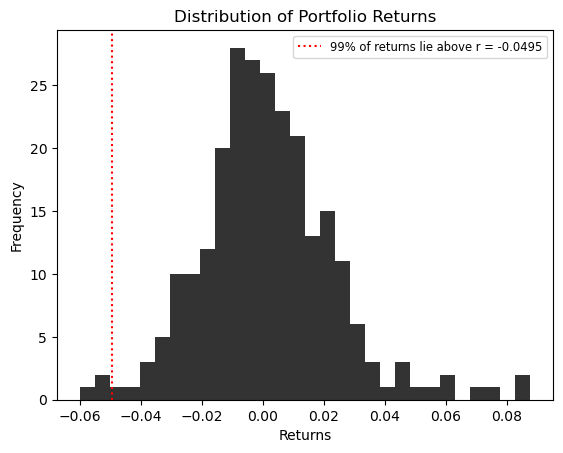

In [69]:
# Calculate current portfolio market value and weights
latest_prices = working_df.iloc[-1, 1:]

market_values = np.array([
    portfolio_dict['AAL'] * latest_prices['Adj Close_AAL'],
    portfolio_dict['DAL'] * latest_prices['Adj Close.1_DAL'],
    portfolio_dict['UAL'] * latest_prices['Adj Close.2_UAL']
])
total_value = np.sum(market_values)
weights = market_values / total_value

# Calculate log returns
working_df['AAL returns'] = np.log(working_df['Adj Close_AAL'] / working_df['Adj Close_AAL'].shift(1))
working_df['DAL returns'] = np.log(working_df['Adj Close.1_DAL'] / working_df['Adj Close.1_DAL'].shift(1))
working_df['UAL returns'] = np.log(working_df['Adj Close.2_UAL'] / working_df['Adj Close.2_UAL'].shift(1))

# Compute portfolio returns using historical data
returns_df = working_df[['AAL returns', 'DAL returns', 'UAL returns']].dropna()
portfolio_returns = returns_df.dot(weights)

# Compute Historical VaR at 99% confidence level
confidence_level = 0.99
var_threshold = abs(np.percentile(portfolio_returns, (1 - confidence_level) * 100))
historical_var = var_threshold * total_value

# Print results
print(f"Market Values: {market_values}\n")
print(f"Total Portfolio Value: ${total_value:,.2f}\n")
print(f"Asset Weights: {weights}\n")
print(f"Historical VaR at {confidence_level * 100}% confidence: ${historical_var:,.2f}\n\n")

plt.hist(portfolio_returns, bins=30, color='black', alpha = 0.8);
plt.title('Distribution of Portfolio Returns');
plt.ylabel('Frequency');
plt.xlabel('Returns');
plt.axvline(np.percentile(portfolio_returns, (1 - confidence_level) * 100), color = 'red', linestyle=':', label = f'99% of returns lie above r = {(np.percentile(portfolio_returns, (1 - confidence_level) * 100)):.4f}');
plt.legend(fontsize = 'small');

Historical VaR at 99.0% confidence: $16161562.13


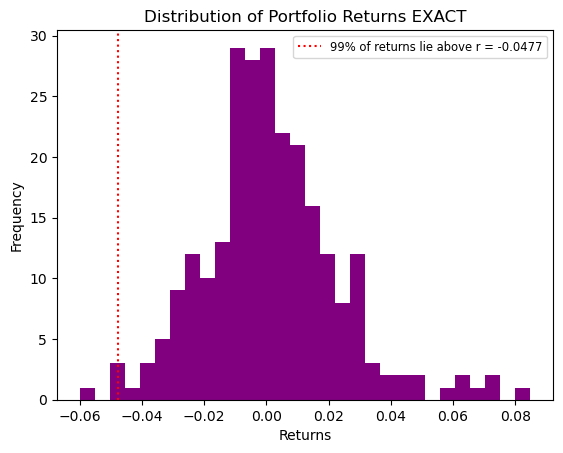

In [70]:
# This is because the log returns are approximate when using weighted portfolio of different assets.
portfolio_returns = list(portfolio_df['Portfolio Returns'].values)[1:]
print(f'Historical VaR at {confidence_level * 100}% confidence: ${(abs(np.percentile(portfolio_returns, 0.99))*total_value):.2f}')
plt.hist(portfolio_returns, bins=30, color ='purple');
plt.title('Distribution of Portfolio Returns EXACT');
plt.ylabel('Frequency');
plt.xlabel('Returns');
plt.axvline(np.percentile(portfolio_returns, (1 - confidence_level) * 100), color = 'red', linestyle=':', label = f'99% of returns lie above r = {(np.percentile(portfolio_returns, (1 - confidence_level) * 100)):.4f}');
plt.legend(fontsize = 'small');